In [168]:
%load_ext autoreload

import sys
sys.path.append("../utils/")
from hadamard_bench import *
# general imports
import matplotlib.pyplot as plt
%matplotlib inline

# AWS imports: Import Braket SDK modules
from braket.circuits import Circuit, Gate, Instruction, circuit, Observable
from braket.devices import LocalSimulator
from braket.aws import AwsDevice
import numpy as np

import functools
import time

from braket_ez.scanner import DeviceUtils,dump_tasks,load_tasks,TaskScanner,DeviceScanner
from braket_ez.Ionq_compiler import IonQCompiler
from braket_ez.circuits import circuit_gate_number
from braket_ez.noise_simulation import apply_aspenm2_noise,apply_ionq11_noise

import json



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
@circuit.subroutine(register=True)
def GHZ (n_qubits):
    """
    Creates a GHZ circuit with n_qubits
    
    Parameters:
    ----------------
    n_qubits : int #of qubits
    """
    out = Circuit().h([0])
    for i in range(n_qubits-1):
        out.cnot(0,i+1)

    return out
        

In [7]:
DeviceUtils.device_ids

['ls',
 'sv1',
 'dm1',
 'tn1',
 'ionq11',
 'oqc-lucy',
 'rigetti-AspenM2',
 'quera-Aquila',
 'xanadu-Borealis']

In [8]:
rigetti = DeviceUtils.get_device('rigetti-AspenM2')
ion_q = DeviceUtils.get_device('ionq11')
rigetti.is_available
#rigetti = LocalSimulator()
# ion_q = LocalSimulator()

True

In [9]:
shots_rigetti = 10_000
shots_ionq=1_000
#set_n_qubits = range(3,10)
n_qubits_list = [2,4,6,8,10,11]

print(n_qubits_list)

[2, 4, 6, 8, 10, 11]


In [12]:
id_dict = {}
rigetti_tasks = []
for n_qubits in n_qubits_list:
    id_dict[str(n_qubits)] = {}
    
    circ = GHZ (n_qubits)
    #print(circ)
    rigetti_task = rigetti.run(circ,shots=shots_rigetti)
    rigetti_tasks.append(rigetti_task)
    
    id_dict[str(n_qubits)] = {'rigetti' : {'id' : rigetti_task.id,'BenchType':'GHZ','n_shots':shots_rigetti,'n_qubits':n_qubits}}

In [14]:
rigetti_ids = [task.id for task in rigetti_tasks]

In [20]:
dump_tasks(rigetti_tasks,labels=n_qubits_list,filename='Task_files/GHZ_m2_10k_2.json')

In [21]:
rigetti_task_scanners=[task for task in load_tasks('Task_files/GHZ_m2_10k_2.json').values()]

In [15]:
rigetti_task_scanners = [BraketTaskScanner(qtask=task) for task in rigetti_tasks]

In [22]:
status_rigetti = [task.get_status() for task in rigetti_task_scanners]
print(status_rigetti)

['COMPLETED', 'COMPLETED', 'COMPLETED', 'COMPLETED', 'COMPLETED', 'COMPLETED']


In [6]:
rigetti_ids=load_ids('Task_files/GHZ_m2_10k_2.json')
rigetti_task_scanners = [BraketTaskScanner(task_arn=arn) for arn in rigetti_ids]

In [23]:
results_rigetti = [qtask.get_results() for qtask in rigetti_task_scanners]

In [24]:
all_ones = np.zeros(len(n_qubits_list))
all_zeros =np.zeros(len(n_qubits_list))
other = np.zeros(len(n_qubits_list))

for i,qubit_number in enumerate(n_qubits_list):
    results = results_rigetti[i]
    meas_probs =results.measurement_probabilities
    all_ones[i] = meas_probs['1'*(qubit_number)] if '1'*(qubit_number) in meas_probs.keys() else 0
    all_zeros[i] = meas_probs['0'*(qubit_number)]if '0'*(qubit_number) in meas_probs.keys() else 0
    other[i] = 1 - all_ones[i] - all_zeros[i]

measure_rigetti = {
    'qubit_n' : n_qubits_list,
    'all_zeros':all_zeros,
    'all_ones':all_ones,
    'other':other
}
measure_rigetti

{'qubit_n': [2, 4, 6, 8, 10, 11],
 'all_zeros': array([0.4207, 0.1191, 0.1066, 0.0324, 0.0097, 0.0053]),
 'all_ones': array([4.345e-01, 1.512e-01, 3.620e-02, 2.700e-03, 6.000e-04, 2.000e-04]),
 'other': array([0.1448, 0.7297, 0.8572, 0.9649, 0.9897, 0.9945])}

# RIGETTI ASPEN M-2

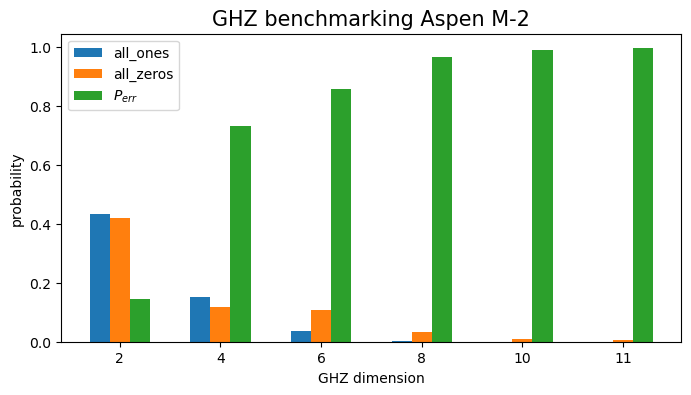

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))


bar_width = .2
x = np.arange(len(n_qubits_list))

ax.bar(x, measure_rigetti['all_ones'],
            width=bar_width,
           label = 'all_ones')

ax.bar(x+bar_width, measure_rigetti['all_zeros'],
            width=bar_width,
           label = 'all_zeros')

ax.bar(x+2*bar_width, measure_rigetti['other'],
            width=bar_width,
           label = '$P_{err}$')


ax.set_xticks(x + bar_width )
ax.set_xticklabels(measure_rigetti['qubit_n'])
ax.set_title('GHZ benchmarking Aspen M-2',size=15)
ax.set_xlabel('GHZ dimension')
ax.set_ylabel('probability')
ax.legend()

# IonQ compensated
Le simulazioni di Ionq sono anch'esse basate su GHZ ma aggiungendo randomicamente delle porte a singolo/due gates per mettere in luce che il suo vantaggio su Rigetti non dipende solamente da una minor overhead di compilazione

In [27]:
ion_q_compiler = IonQCompiler

In [28]:
compiled_circuits_ion_q = [ion_q_compiler.compile(GHZ(n_qubits)) for n_qubits in n_qubits_list]
N_gates_ion_q = [len(ion_q_compiler.compile(GHZ(n_qubits)).instructions) for n_qubits in n_qubits_list]

In [32]:
compiled_circuits_rigetti = [task.get_compiled_circuit() for task in rigetti_task_scanners]

braket_circs_rigetti = [transpile_quil_to_braket(quil_circ)[0] for quil_circ in compiled_circuits_rigetti]
braket_circs_ion_q = compiled_circuits_ion_q

rigetti_gate_number_dict = [circuit_gate_number(circ) for circ in braket_circs_rigetti]
ionq_gate_number_dict = [circuit_gate_number(circ) for circ in braket_circs_ion_q]

In [104]:
def compensated_ghz_ion_q(n_qubits,rigetti_gate_number_dict):
    """
    It takes the number of gates of rigetti for the given circuit and then applies them to the IonQ circuit
    """
    ion_q_compiler = IonQCompiler
    GHZ_standard = GHZ (n_qubits)
    #we first compile the ionq version
    GHZ_std_compiled = ion_q_compiler.compile(GHZ_standard)
    
    #we find how many gates we need to add
    rigetti_entangling_gates = rigetti_gate_number_dict['entangling']
    rigetti_one_qubit_gates = rigetti_gate_number_dict['1q']
    ion_q_entangling_gates = circuit_gate_number(GHZ_std_compiled)['entangling']
    ion_q_one_qubit_gates = circuit_gate_number(GHZ_std_compiled)['1q']
    
    
    GHZ_compensated = GHZ_std_compiled
    n_entangled_to_compensate = int(np.ceil(.5*(rigetti_entangling_gates-ion_q_entangling_gates)))
    n_single_to_compensate = int(np.ceil(.5*(rigetti_one_qubit_gates-ion_q_one_qubit_gates)))
    
    
    for _ in range(n_entangled_to_compensate):
        #all the entangling gates have the qubit 0 as control
        theta1,theta2 = np.random.random(2)*2*np.pi
        q1= 0
        q2 = np.random.randint(low=1,high=n_qubits)
        
        #we then apply the gate and its hermitian
        GHZ_compensated.ms(q1,q2,theta1,theta2).ms(q1,q2,theta1,theta2+np.pi)
       
    
    for _ in range (n_single_to_compensate):
        #we choose the qubit at random. Actually it is not really random on rigetti but equally distributed
        #but for sake of simplicity 
        coin = np.random.random()
        theta = np.random.random()*2*np.pi
        q = np.random.randint(n_qubits)
        if coin >.5:     
            GHZ_compensated.gpi(q,theta).gpi(q,theta)
        else:
            GHZ_compensated.gpi2(q,theta).gpi2(q,theta+np.pi)

    return Circuit().add_verbatim_box(GHZ_compensated)
        

In [109]:
id_dict = {}
ionq_tasks = []
for i,n_qubits in enumerate(n_qubits_list):
    id_dict[str(n_qubits)] = {}
    
    
    circ = compensated_ghz_ion_q(n_qubits,rigetti_gate_number_dict[i])
    #print(circ)

    ionq_task = ion_q.run(circ,shots=shots_ionq)
    ionq_tasks.append(ionq_task)


In [114]:
dump_tasks(ionq_tasks,labels=n_qubits_list,filename='Task_files/ionq_GHZ_compensated_1k.json')

In [115]:
ion_q_task_scanners = [task_scanner for task_scanner in load_tasks('Task_files/ionq_GHZ_compensated_1k.json').values()]

In [122]:
status_ion_q = [task.get_status() for task in ion_q_task_scanners]
print(status_ion_q)

['COMPLETED', 'COMPLETED', 'COMPLETED', 'COMPLETED', 'COMPLETED', 'COMPLETED']


In [123]:
results_ion_q = [qtask.get_results() for qtask in ion_q_task_scanners]

In [188]:
all_ones = np.zeros(len(n_qubits_list))
all_zeros =np.zeros(len(n_qubits_list))
other = np.zeros(len(n_qubits_list))

for i,qubit_number in enumerate(n_qubits_list):
    results = results_ion_q[i]
    meas_probs =results.measurement_probabilities
    all_ones[i] = meas_probs['1'*(qubit_number)] if '1'*(qubit_number) in meas_probs.keys() else 0
    all_zeros[i] = meas_probs['0'*(qubit_number)]if '0'*(qubit_number) in meas_probs.keys() else 0
    other[i] = 1 - all_ones[i] - all_zeros[i]
    
measure_ion_q = {
    'qubit_n' : n_qubits_list,
    'all_zeros':all_zeros,
    'all_ones':all_ones,
    'other':other
}
measure_ion_q

{'qubit_n': [2, 4, 6, 8, 10, 11],
 'all_zeros': array([0.457, 0.381, 0.203, 0.038, 0.012, 0.012]),
 'all_ones': array([0.5  , 0.376, 0.171, 0.039, 0.015, 0.018]),
 'other': array([0.043, 0.243, 0.626, 0.923, 0.973, 0.97 ])}

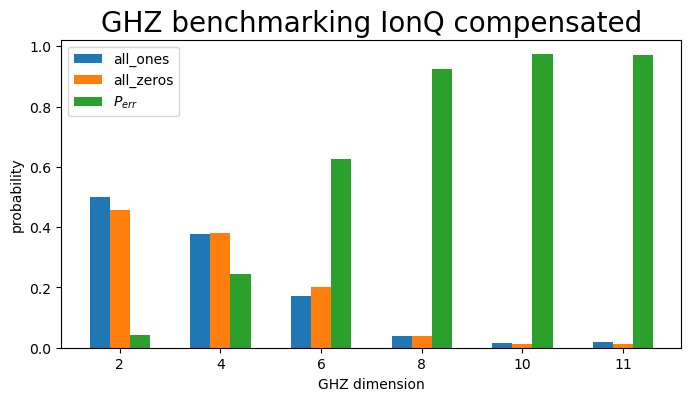

In [125]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))


bar_width = .2
x = np.arange(len(n_qubits_list))

ax.bar(x, measure_ion_q['all_ones'],
            width=bar_width,
           label = 'all_ones')

ax.bar(x+bar_width, measure_ion_q['all_zeros'],
            width=bar_width,
           label = 'all_zeros')

ax.bar(x+2*bar_width, measure_ion_q['other'],
            width=bar_width,
           label = '$P_{err}$')


ax.set_xticks(x + bar_width )
ax.set_xticklabels(measure_ion_q['qubit_n'])
ax.set_title('GHZ benchmarking IonQ compensated',size=20)
ax.set_xlabel('GHZ dimension')
ax.set_ylabel('probability')
ax.legend()










# Rigetti/IonQ comparison







In [126]:
compiled_circuits_rigetti = [task.get_compiled_circuit() for task in rigetti_task_scanners]


In [127]:
N_gates_rigetti = [len([line for line in circ.splitlines() if 'MEASURE' not in line])-3 for circ in compiled_circuits_rigetti]


In [128]:
ion_q_compiler = IonQCompiler()

In [129]:
compiled_circuits_ion_q = [compensated_ghz_ion_q(n_qubits,rigetti_gate_number_class[i]) for i,n_qubits in enumerate(n_qubits_list)]
N_gates_ion_q = [len(compiled_circuits_ion_q[i].instructions) - 2 for i,n_qubits in enumerate(n_qubits_list)]

### Analysis on total gates

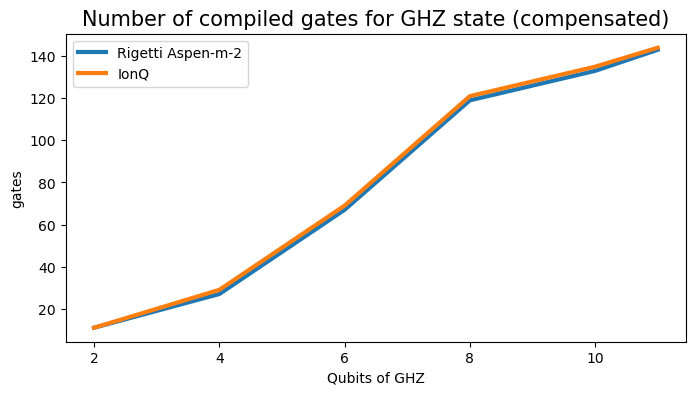

In [130]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))
ax.plot(n_qubits_list,N_gates_rigetti,
       label='Rigetti Aspen-m-2',
       lw = 3)

ax.plot(n_qubits_list,N_gates_ion_q,
       label='IonQ',
       lw = 3)

ax.set_title('Number of compiled gates for GHZ state (compensated)',size=15)
ax.set_xlabel('Qubits of GHZ')
ax.set_ylabel('gates')
ax.legend()

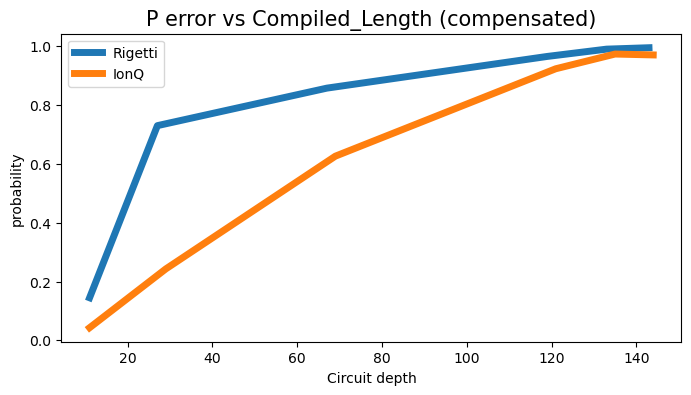

In [131]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))



ax.plot(N_gates_rigetti, measure_rigetti['other'],
            lw=5,
           label = 'Rigetti')

ax.plot(N_gates_ion_q, measure_ion_q['other'],
            lw=5,
           label = 'IonQ')


ax.set_title('P error vs Compiled_Length (compensated)',size=15)
ax.set_xlabel('Circuit depth')
ax.set_ylabel('probability')
ax.legend()

### Entangling gates

In [143]:
braket_circs_rigetti = [transpile_quil_to_braket(quil_circ)[0] for quil_circ in compiled_circuits_rigetti]
braket_circs_ion_q = compiled_circuits_ion_q

rigetti_entangling_gate_number = [circuit_gate_number(circ)['entangling'] for circ in braket_circs_rigetti]
ionq_entangling_gate_number = [circuit_gate_number(circ)['entangling'] for circ in braket_circs_ion_q]

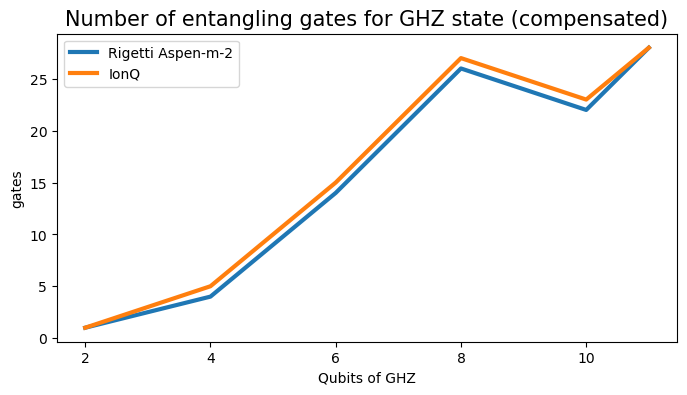

In [134]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))
ax.plot(n_qubits_list,rigetti_entangling_gate_number,
       label='Rigetti Aspen-m-2',
       lw = 3)

ax.plot(n_qubits_list,ionq_entangling_gate_number,
       label='IonQ',
       lw = 3)

ax.set_title('Number of entangling gates for GHZ state (compensated)',size=15)
ax.set_xlabel('Qubits of GHZ')
ax.set_ylabel('gates')
ax.legend()

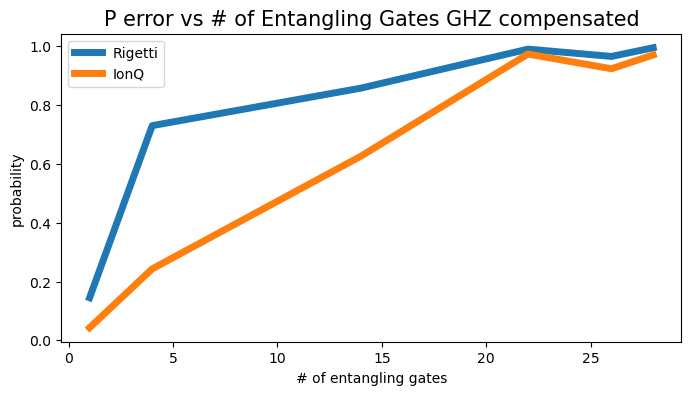

In [158]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))

order = np.argsort(rigetti_entangling_gate_number)

x = np.array(rigetti_entangling_gate_number)[order]
y=np.array(measure_rigetti['other'])[order]
ax.plot(x,y,
            lw=5,
           label = 'Rigetti')

x = np.array(rigetti_entangling_gate_number)[order]
y=np.array(measure_ion_q['other'])[order]
ax.plot(x,y,
            lw=5,
           label = 'IonQ')


ax.set_title('P error vs # of Entangling Gates GHZ compensated',size=15)
ax.set_xlabel('# of entangling gates')
ax.set_ylabel('probability')
ax.legend()

### Single-qubit gates

In [160]:
single_qubit_rigetti = [circuit_gate_number(circ)['1q'] for circ in braket_circs_rigetti]
single_qubit_ionq = [circuit_gate_number(circ)['1q'] for circ in braket_circs_ion_q]

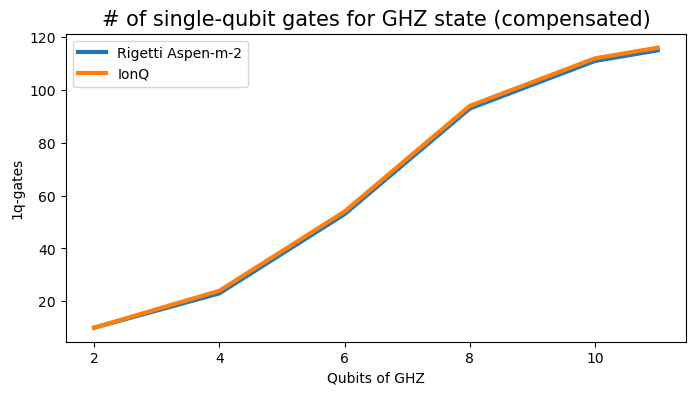

In [164]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))
ax.plot(n_qubits_list,single_qubit_rigetti,
       label='Rigetti Aspen-m-2',
       lw = 3)

ax.plot(n_qubits_list,single_qubit_ionq,
       label='IonQ',
       lw = 3)

ax.set_title('# of single-qubit gates for GHZ state (compensated)',size=15)
ax.set_xlabel('Qubits of GHZ')
ax.set_ylabel('1q-gates')
ax.legend()

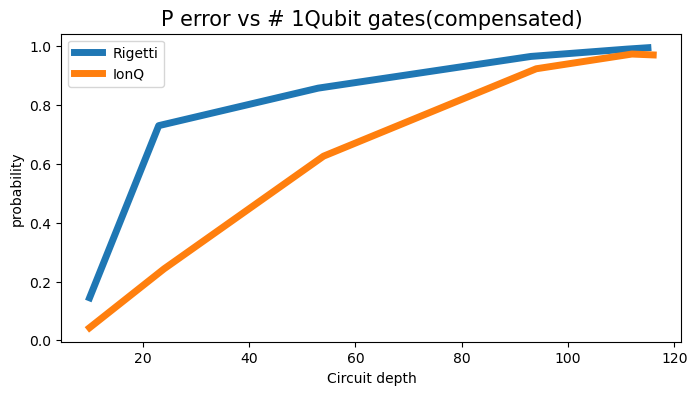

In [165]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))


ax.plot(single_qubit_rigetti, measure_rigetti['other'],
            lw=5,
           label = 'Rigetti')

ax.plot(single_qubit_ionq, measure_ion_q['other'],
            lw=5,
           label = 'IonQ')


ax.set_title('P error vs # 1Qubit gates(compensated)',size=15)
ax.set_xlabel('Circuit depth')
ax.set_ylabel('probability')
ax.legend()

# Comparison with Standard GHZ

In [239]:
ionq_GHZstd_task_scanners = [task for task in load_tasks('Task_files/GHZ_ionq_1k').values()]
results_ion_q_GHZ_std = [qtask.get_results()for qtask in ionq_GHZstd_task_scanners]

ionq_GHZcomp_task_scanners = [task for task in load_tasks('Task_files/ionq_GHZ_compensated_1k.json').values()]
results_ion_q_GHZ_comp = [qtask.get_results()for qtask in ionq_GHZcomp_task_scanners]


# Analyzing the results
# Initialize variables to store measurement probabilities
all_ones = np.zeros(len(n_qubits_list))
all_zeros =np.zeros(len(n_qubits_list))
other = np.zeros(len(n_qubits_list))

# Iterate over tasks and extract measurement probabilities for different outcomes
for i,qubit_number in enumerate(n_qubits_list):
    results = results_ion_q_GHZ_std[i]
    meas_probs =results.measurement_probabilities
    all_ones[i] = meas_probs['1'*(qubit_number)] if '1'*(qubit_number) in meas_probs.keys() else 0
    all_zeros[i] = meas_probs['0'*(qubit_number)]if '0'*(qubit_number) in meas_probs.keys() else 0
    other[i] = 1 - all_ones[i] - all_zeros[i]
    
measure_ion_q_std = {
    'qubit_n' : n_qubits_list,
    'all_zeros':all_zeros,
    'all_ones':all_ones,
    'other':other
}

# Repeat process for second set of tasks (compensated GHZ)
# Initialize variables to store measurement probabilities
all_ones = np.zeros(len(n_qubits_list))
all_zeros =np.zeros(len(n_qubits_list))
other = np.zeros(len(n_qubits_list))

for i,qubit_number in enumerate(n_qubits_list):
    results = results_ion_q_GHZ_comp[i]
    meas_probs =results.measurement_probabilities
    all_ones[i] = meas_probs['1'*(qubit_number)] if '1'*(qubit_number) in meas_probs.keys() else 0
    all_zeros[i] = meas_probs['0'*(qubit_number)]if '0'*(qubit_number) in meas_probs.keys() else 0
    other[i] = 1 - all_ones[i] - all_zeros[i]
    
measure_ion_q_GHZ_comp = {
    'qubit_n' : n_qubits_list,
    'all_zeros':all_zeros,
    'all_ones':all_ones,
    'other':other
}



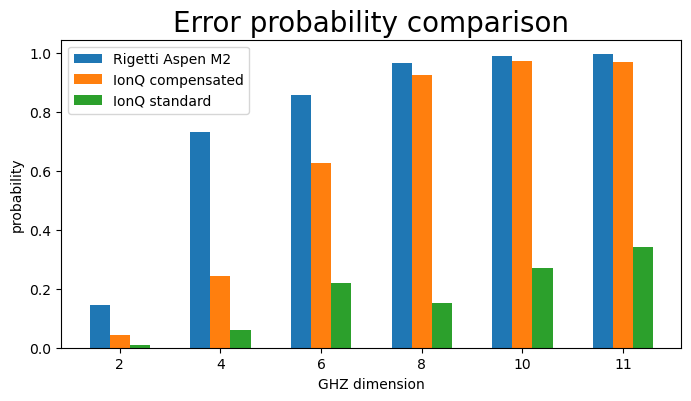

In [241]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))

bar_width = .2
x = np.arange(len(n_qubits_list))

ax.bar(x, measure_rigetti['other'],
            width=bar_width,
           label = 'Rigetti Aspen M2')

ax.bar(x+bar_width, measure_ion_q_GHZ_comp['other'],
            width=bar_width,
           label = 'IonQ compensated')

ax.bar(x+2*bar_width, measure_ion_q_std['other'],
            width=bar_width,
           label = 'IonQ standard')


ax.set_xticks(x + bar_width )
ax.set_xticklabels(measure_ion_q['qubit_n'])
ax.set_title('Error probability comparison',size=20)
ax.set_xlabel('GHZ dimension')
ax.set_ylabel('probability')
ax.legend()

-----------------------------------------------------------------------------------------------

# SIMULAZIONI

In [166]:
local_simulator = DeviceUtils.get_device('dm1')

## RIGETTI

In [171]:
circuits =[Quil_to_Braket_Transpiler(scanner.get_compiled_circuit(),quil_rewiring=True).braket_circ for scanner in rigetti_task_scanners]
simulation_tasks = []
labels = []
qubit_mappings_sim = []
for i,n_qubits in enumerate(n_qubits_list):
    
    circ = circuits[i]
    noisy_circ,qubit_mapping = apply_aspenm2_noise(circ)
    
    simulation_task = local_simulator.run(noisy_circ,shots=10_000)
    
    simulation_tasks.append(simulation_task)
    qubit_mappings_sim.append(qubit_mapping)
    labels.append( "ls_rigetti_ghz_s1000_#q_" + str(n_qubits))

In [172]:
dump_tasks(simulation_tasks, labels, filename = "Task_files/GHZ_ls_Rig_comp.json")

In [178]:
ls_tasks = load_tasks("Task_files/GHZ_ls_Rig_comp.json")
ls_scanners = [task_scan for task_scan in ls_tasks.values()]

status = [task.get_status() for task in ls_scanners]
print(status)

['COMPLETED', 'COMPLETED', 'COMPLETED', 'COMPLETED', 'COMPLETED', 'COMPLETED']


In [179]:
all_ones = np.zeros(len(n_qubits_list))
all_zeros =np.zeros(len(n_qubits_list))
other = np.zeros(len(n_qubits_list))

ls_results = [scanner.get_results() for scanner in ls_scanners]


for i,qubit_number in enumerate(n_qubits_list):
    results = ls_results[i]
    meas_probs =results.measurement_probabilities
    all_ones[i] = meas_probs['1'*(qubit_number)] if '1'*(qubit_number) in meas_probs.keys() else 0
    all_zeros[i] = meas_probs['0'*(qubit_number)]if '0'*(qubit_number) in meas_probs.keys() else 0
    other[i] = 1 - all_ones[i] - all_zeros[i]
    
measure_ls = {
    'qubit_n' : n_qubits_list,
    'all_zeros':all_zeros,
    'all_ones':all_ones,
    'other':other
}
measure_ls

{'qubit_n': [2, 4, 6, 8, 10, 11],
 'all_zeros': array([0.4972, 0.4666, 0.2787, 0.1275, 0.1213, 0.1233]),
 'all_ones': array([0.4785, 0.4527, 0.2746, 0.1255, 0.1179, 0.1153]),
 'other': array([0.0243, 0.0807, 0.4467, 0.747 , 0.7608, 0.7614])}

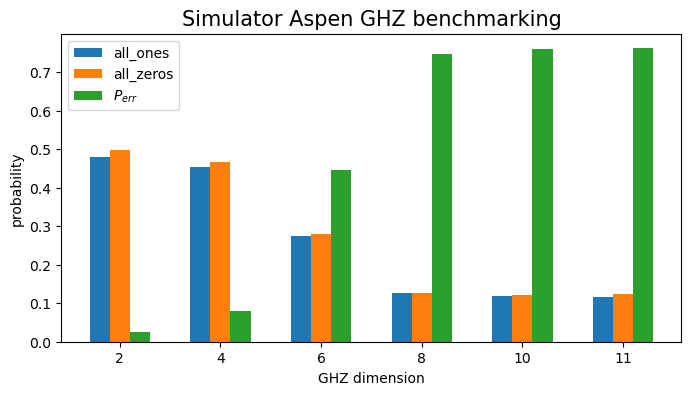

In [180]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))

bar_width = .2
x = np.arange(len(n_qubits_list))

ax.bar(x, measure_ls['all_ones'],
            width=bar_width,
           label = 'all_ones')

ax.bar(x+bar_width, measure_ls['all_zeros'],
            width=bar_width,
           label = 'all_zeros')

ax.bar(x+2*bar_width, measure_ls['other'],
            width=bar_width,
           label = '$P_{err}$')


ax.set_xticks(x + bar_width )
ax.set_xticklabels(measure_rigetti['qubit_n'])
ax.set_title('Simulator Aspen GHZ benchmarking',size = 15)
ax.set_xlabel('GHZ dimension')
ax.set_ylabel('probability')
ax.legend()

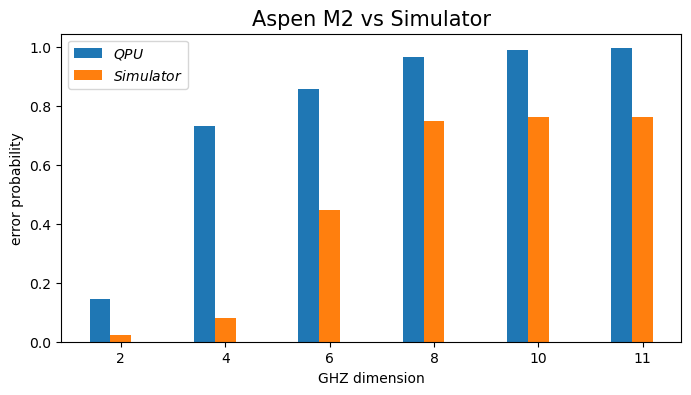

In [181]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))


bar_width = .2
x = np.arange(len(n_qubits_list))


ax.bar(x, measure_rigetti['other'],
            width=bar_width,
           label = '$QPU$')
ax.bar(x+bar_width, measure_ls['other'],
            width=bar_width,
           label = '$Simulator$')


ax.set_xticks(x + bar_width )
ax.set_xticklabels(measure_rigetti['qubit_n'])
ax.set_title('Aspen M2 vs Simulator',size = 15)
ax.set_xlabel('GHZ dimension')
ax.set_ylabel('error probability')
ax.legend()

## IonQ

In [93]:

simulation_tasks_ion_q = []
labels = []
for i,n_qubits in enumerate(n_qubits_list):
    
    #removing verbatim box
    circ = Circuit()
    for instruction in braket_circs_ion_q[i].instructions[1:-1]:
        circ.add_instruction(instruction)
    noisy_circ = simulate_noise_ion_q_11(circ)
    
    simulation_task = local_simulator.run(noisy_circ,shots=10_000)
    
    simulation_tasks_ion_q.append(simulation_task)
    labels.append( "ls_ionq_ghz_s10000_#q_" + str(n_qubits))

In [95]:
dump_tasks(simulation_tasks_ion_q, labels, filename = "ionq_GHZ_l_s_.json")

In [102]:
ls_tasks = load_tasks("ionq_GHZ_l_s_.json")
ls_scanners = [BraketTaskScanner(qtask = task) for key, task in ls_tasks.items()]

status = [task.get_status() for task in ls_scanners]
print(status)

['COMPLETED', 'COMPLETED', 'COMPLETED', 'COMPLETED', 'COMPLETED']


In [103]:
all_ones = np.zeros(len(n_qubits_list))
all_zeros =np.zeros(len(n_qubits_list))
other = np.zeros(len(n_qubits_list))

ls_results = [scanner.get_results() for scanner in ls_scanners]


for i,qubit_number in enumerate(n_qubits_list):
    results = ls_results[i]
    meas_probs =results.measurement_probabilities
    all_ones[i] = meas_probs['1'*(qubit_number)] if '1'*(qubit_number) in meas_probs.keys() else 0
    all_zeros[i] = meas_probs['0'*(qubit_number)]if '0'*(qubit_number) in meas_probs.keys() else 0
    other[i] = 1 - all_ones[i] - all_zeros[i]
    
measure_ls = {
    'qubit_n' : n_qubits_list,
    'all_zeros':all_zeros,
    'all_ones':all_ones,
    'other':other
}
measure_ls

{'qubit_n': [2, 4, 6, 8, 10],
 'all_zeros': array([0.3691, 0.2126, 0.0734, 0.0374, 0.0072]),
 'all_ones': array([0.3702, 0.2052, 0.0712, 0.0334, 0.0065]),
 'other': array([0.2607, 0.5822, 0.8554, 0.9292, 0.9863])}

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))

bar_width = .2
x = np.arange(len(n_qubits_list))

ax.bar(x, measure_ls['all_ones'],
            width=bar_width,
           label = 'all_ones')

ax.bar(x+bar_width, measure_ls['all_zeros'],
            width=bar_width,
           label = 'all_zeros')

ax.bar(x+2*bar_width, measure_ls['other'],
            width=bar_width,
           label = '$P_{err}$')


ax.set_xticks(x + bar_width )
ax.set_xticklabels(measure_rigetti['qubit_n'])
ax.set_title('Simulator IonQ GHZ benchmarking',size = 15)
ax.set_xlabel('GHZ dimension')
ax.set_ylabel('probability')
ax.legend()

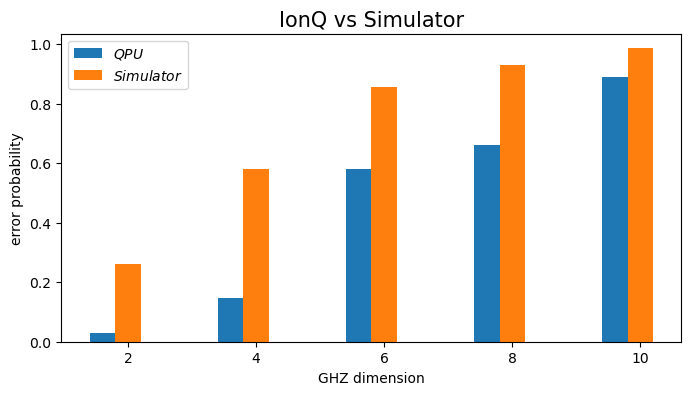

In [105]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))


bar_width = .2
x = np.arange(len(n_qubits_list))


ax.bar(x, measure_ion_q['other'],
            width=bar_width,
           label = '$QPU$')
ax.bar(x+bar_width, measure_ls['other'],
            width=bar_width,
           label = '$Simulator$')


ax.set_xticks(x + bar_width )
ax.set_xticklabels(measure_rigetti['qubit_n'])
ax.set_title('IonQ vs Simulator',size = 15)
ax.set_xlabel('GHZ dimension')
ax.set_ylabel('error probability')
ax.legend()